<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





# Student Mingyao:

# Imports

In [1]:
import numpy as np
import pickle
import requests
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
# other imports go here

# Data loading and inspection

In [2]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [3]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)
           
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):  # get the label and data by index
        x = self.data[index]
        y = self.targets[index]
        return x, y
    

In [4]:
Classes = {0:"Trousers", 1:"Sandals", 2:"Sneakers", 3:"Bags", 4:"Ankle boots", 5:"anomaly"}

In [5]:
labeled_data=full_data['labeled_data']['data']/255.0
labeled_label=full_data['labeled_data']['labels']

unlabeled_data=full_data['unlabeled_data']/255.0

rep_set1_data=full_data['representative_set_1']['data']/255.0
rep_set1_label=full_data['representative_set_1']['labels']

rep_set2_data=full_data['representative_set_2']['data']/255.0
rep_set2_label=full_data['representative_set_2']['labels']


labeled_label_index=labeled_label.nonzero()[1]
rep_set1_label_index=rep_set1_label.nonzero()[1]
rep_set2_label_index=rep_set2_label.nonzero()[1]

In [6]:
labeled_dataset=MyDataset(labeled_data,labeled_label_index)
rep_set1_dataset=MyDataset(rep_set1_data,rep_set1_label_index)
rep_set2_dataset=MyDataset(rep_set2_data,rep_set2_label_index)

In [7]:
batch_size_unlabel = 100
batch_size_label = 50
anomaly_label = 5

kwargs = {'num_workers': 1, 'pin_memory': True}

# obtain the indices corresponding to normal and anomalous data from rep_set1 and rep_set2 respectively
#anomaly indices
anomaly_indices_rep1 = (rep_set1_dataset.targets == anomaly_label).nonzero().flatten()
anomaly_indices_rep2 = (rep_set2_dataset.targets == anomaly_label).nonzero().flatten()
#anomaly figure data
anomaly_data_rep1=rep_set1_dataset.data[anomaly_indices_rep1]
anomaly_data_rep2=rep_set2_dataset.data[anomaly_indices_rep2]



#normal indices
normal_indices_rep1 = (rep_set1_dataset.targets != anomaly_label).nonzero().flatten()
normal_indices_rep2 = (rep_set2_dataset.targets != anomaly_label).nonzero().flatten()
#normal figure data
normal_data_rep1=rep_set1_dataset.data[normal_indices_rep1 ]
normal_data_rep2=rep_set2_dataset.data[normal_indices_rep2 ]






# use a SubsetRandomSampler to sample only images from the normal/anomaly dataset, respectively
anomaly_sampler_rep1 = SubsetRandomSampler(anomaly_indices_rep1)
anomaly_sampler_rep2 = SubsetRandomSampler(anomaly_indices_rep2)
normal_sampler_rep1 = SubsetRandomSampler(normal_indices_rep1)
normal_sampler_rep2 = SubsetRandomSampler(normal_indices_rep2)



# setup DataLoaders    rep1 for trainning  and rep2 for validation
# for testing of the classifier NN model & for t-SNE plot
# for classification
anomaly_loader_rep1 = DataLoader(dataset=rep_set1_dataset, batch_size=batch_size_label, sampler=anomaly_sampler_rep1)
anomaly_loader_rep2 = DataLoader(dataset=rep_set2_dataset, batch_size=batch_size_label, sampler=anomaly_sampler_rep2)
normal_loader_rep1 = DataLoader(dataset=rep_set1_dataset, batch_size=batch_size_label, sampler=normal_sampler_rep1)
normal_loader_rep2 = DataLoader(dataset=rep_set2_dataset, batch_size=batch_size_label, sampler=normal_sampler_rep2)


# for training the classification model supervised model (with label)  同时通过vae，通过
labeled_data_loader=DataLoader(dataset=labeled_dataset,batch_size=batch_size_label)
# for training the VAE model  unsupervised learning (no label)
unlabeled_data_loader = DataLoader(dataset=unlabeled_data, batch_size=batch_size_unlabel, **kwargs)            


In [8]:
def show_images(x, ncols=10):
    _, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx][0], cmap="Greys")
        ax[idx].axis('off')
    plt.show()

(26000, 1, 32, 32)


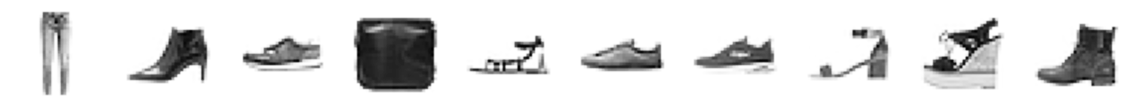

(2000, 1, 32, 32)


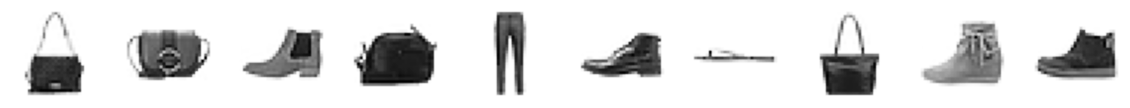

torch.Size([1000, 1, 32, 32])


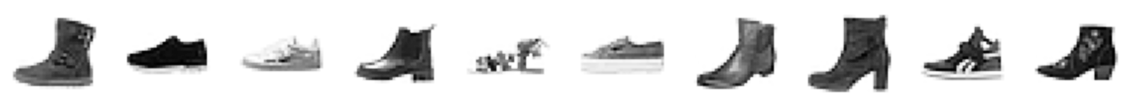

torch.Size([1000, 1, 32, 32])


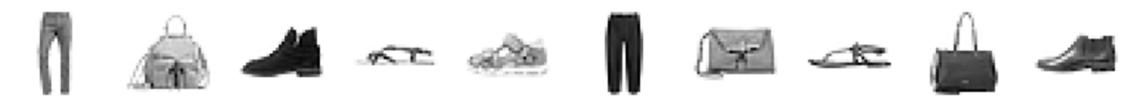

torch.Size([52, 1, 32, 32])


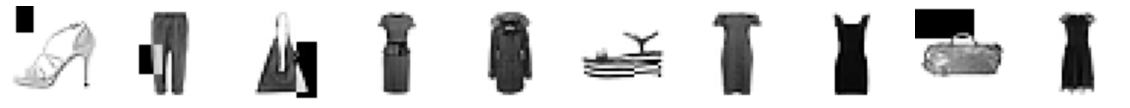

torch.Size([52, 1, 32, 32])


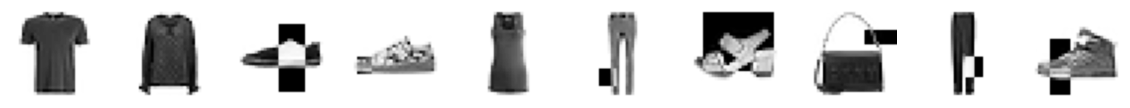

In [9]:
plot_list=[unlabeled_data,labeled_data,normal_data_rep1,normal_data_rep2,anomaly_data_rep1,anomaly_data_rep2]
for i, loader in enumerate(plot_list):
    print(loader.shape)
    show_images(loader)

# Model definitions

In [10]:
# code for model definitions goes here

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        
        return z

In [12]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr

In [13]:

class MyVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

In [14]:


class MyClassifer(nn.Module):
  def __init__(self):
    super(MyClassifer, self).__init__()

    self.layer1=nn.Sequential(
        nn.Linear(5, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),   
        nn.Linear(128, 64), 
        nn.ReLU(),  
        nn.Linear(64, 10),
    )

    self.layer2=nn.Sequential(
        nn.Linear(20, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),   
        nn.Linear(256, 128), 
        nn.ReLU(),  
        nn.Linear(128, 64),
        nn.ReLU(),  
        nn.Linear(64, 1),
    )


  def forward(self, input1, input2):
    output1 = self.layer1(input1)
    output2 = self.layer1(input2)
    # now we can reshape `output1` and `output2` to 1D and concat them
    combined = torch.cat((output1.view(output1.size(0), -1),
                          output2.view(output2.size(0), -1)), dim=1)
    out = self.layer2(combined)
    return out

# Loss function 

In [15]:

def loss_function_vae(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

loss_function_classifier=nn.MSELoss()

# Training and validation loop

In [32]:
# write your training and validation loop here


# hyper parameters
latent_dim = 5
x_dim = 32*32
hidden_dim = 500
lr_vae = 0.001
lr_classifier = 0.001
epochs_vae = 50
epochs_classier = 100



if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)


VAEmodel = MyVAE(encoder=encoder, decoder=decoder).to(device)
Classifier_model = MyClassifer().to(device)



optimizer_vae=optim.Adam(VAEmodel.parameters(), lr=lr_vae)
optimizer_classifier=optim.Adam(Classifier_model.parameters(), lr=lr_classifier)


In [33]:
# perform training

In [34]:
def train_VAE(num_epochs,dataloader):
    print("Start training VAE...")
    VAEmodel.train()
    Average_losses=[]
    Reconstruction_Losses=[]
    KL_Losses=[]
    for epoch in range(num_epochs):
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        for batch_idx, (x) in enumerate(dataloader):
            # print(x.shape)
            x = x.view(batch_size_unlabel, x_dim).float()
            x = x.to(device)

            optimizer_vae.zero_grad()

            x_reconstr, mu, log_sigma =  VAEmodel(x)
            # print('mu shape:',mu.shape)
            # print('log_sigma shape:',log_sigma.shape)
            loss, reconstr_loss, kl_loss = loss_function_vae(x, x_reconstr, mu, log_sigma)
            
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            
            loss.backward()
            optimizer_vae.step()
            
        n_datapoints = batch_idx * batch_size_unlabel
        Average_loss=overall_loss / n_datapoints
        Reconstruction_Loss=overall_reconstr_loss / n_datapoints
        KL_Loss=overall_kl_loss / n_datapoints


        Average_losses.append(Average_loss)
        Reconstruction_Losses.append(Reconstruction_Loss)
        KL_Losses.append(KL_Loss)
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", Average_loss, "\tReconstruction Loss:", Reconstruction_Loss, "\tKL Loss:", KL_Loss)
        
    print("Training complete!")
    return Average_losses,Reconstruction_Losses,KL_Losses

In [35]:
def train_classifer(num_epochs,dataloader):
    """
    Train the model.
    """
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):

        running_loss = 0.0
        Classifier_model.train()
        print("Starting epoch " + str(epoch+1))
        for batch_idx, (x, y) in enumerate(dataloader):
            # Forward
            (x, y) = (x.to(device), y.to(device))
            x = x.view(len(x), x_dim).float()
            y = y.float()
            _,mu,sigma=VAEmodel(x)
            y_pred = Classifier_model(mu,sigma).view(-1).float()
            loss = loss_function_classifier(y_pred, y)


            # Backward and optimize
            optimizer_classifier.zero_grad()
            loss.backward()
            optimizer_classifier.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(dataloader)
        train_losses.append(avg_train_loss)

        val_running_loss = 0.0

        # check validation loss after every epoch
        with torch.no_grad():
            Classifier_model.eval()
            for batch_idx, (x, y) in enumerate(dataloader):
                # Forward
                (x, y) = (x.to(device), y.to(device))
                x = x.view(len(x), x_dim).float()
                _,mu,sigma=VAEmodel(x)
                y_pred = Classifier_model(mu,sigma).view(-1).float()
                loss = loss_function_classifier(y_pred, y)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(dataloader)
        val_losses.append(avg_val_loss)

        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
              .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
    print("Finished Training")
    return train_losses, val_losses

In [36]:
def plot_loss_vae(average_loss, reconstruction_loss,KL_loss,epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Average loss, reconstruction loss and KL loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, average_loss)
    plt.plot(epoche_range, reconstruction_loss)
    plt.plot(epoche_range, KL_loss)
    plt.legend(['Average loss', 'Reconstruction loss','KL loss'], loc='best')
    plt.show()

In [37]:
def plot_loss(train_loss, val_loss,epoche):
    """
    plot the loss change during the training precedure
    """
    plt.title("Train and validation loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    epoche_range=[i+1 for i in range(epoche)]
    plt.plot(epoche_range, train_loss)
    plt.plot(epoche_range, val_loss)
    plt.legend(['train loss', 'validation loss'], loc='best')
    plt.show()

In [38]:
#trainning the vae model
average_loss,reconstrution_loss,kl_loss=train_VAE(num_epochs=epochs_vae,dataloader=unlabeled_data_loader)


Start training VAE...
	Epoch 1 	Average Loss:  45.55051476909387 	Reconstruction Loss: 41.6640901849813 	KL Loss: 3.8864246991932623
	Epoch 2 	Average Loss:  27.718144927153716 	Reconstruction Loss: 22.317103379886582 	KL Loss: 5.401041481283181
	Epoch 3 	Average Loss:  26.008704574761705 	Reconstruction Loss: 20.190828683035715 	KL Loss: 5.817875910578548
	Epoch 4 	Average Loss:  25.341662852165783 	Reconstruction Loss: 19.31569555098486 	KL Loss: 6.0259673058940635
	Epoch 5 	Average Loss:  24.907992070614142 	Reconstruction Loss: 18.805950117074385 	KL Loss: 6.102041899338652
	Epoch 6 	Average Loss:  24.637943044537284 	Reconstruction Loss: 18.450657181316362 	KL Loss: 6.187285893856329
	Epoch 7 	Average Loss:  24.406850746184244 	Reconstruction Loss: 18.166705228002836 	KL Loss: 6.240145560599662
	Epoch 8 	Average Loss:  24.235272485445826 	Reconstruction Loss: 17.958091777079815 	KL Loss: 6.277180635312349
	Epoch 9 	Average Loss:  24.121213972761826 	Reconstruction Loss: 17.8173385

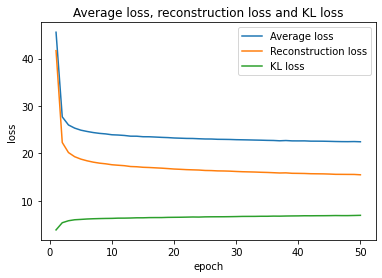

In [40]:
plot_loss_vae(average_loss=average_loss,reconstruction_loss=reconstrution_loss,KL_loss=kl_loss,epoche=epochs_vae)


In [41]:
# training the vae classifier model
train_losses,val_losses=train_classifer(num_epochs=epochs_classier,dataloader=labeled_data_loader)

Starting epoch 1
Epoch [1/100],Train Loss: 2.9623, Valid Loss: 0.81567802
Starting epoch 2
Epoch [2/100],Train Loss: 0.5948, Valid Loss: 0.42966828
Starting epoch 3
Epoch [3/100],Train Loss: 0.4186, Valid Loss: 0.33980057
Starting epoch 4
Epoch [4/100],Train Loss: 0.3360, Valid Loss: 0.29153586
Starting epoch 5
Epoch [5/100],Train Loss: 0.2869, Valid Loss: 0.26858611
Starting epoch 6
Epoch [6/100],Train Loss: 0.2548, Valid Loss: 0.23357817
Starting epoch 7
Epoch [7/100],Train Loss: 0.2415, Valid Loss: 0.22410236
Starting epoch 8
Epoch [8/100],Train Loss: 0.2321, Valid Loss: 0.20973409
Starting epoch 9
Epoch [9/100],Train Loss: 0.2322, Valid Loss: 0.19588495
Starting epoch 10
Epoch [10/100],Train Loss: 0.2109, Valid Loss: 0.19583390
Starting epoch 11
Epoch [11/100],Train Loss: 0.2052, Valid Loss: 0.19678381
Starting epoch 12
Epoch [12/100],Train Loss: 0.2060, Valid Loss: 0.19072398
Starting epoch 13
Epoch [13/100],Train Loss: 0.2111, Valid Loss: 0.18910291
Starting epoch 14
Epoch [14/10

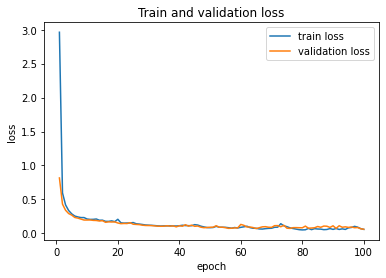

In [42]:
plot_loss(train_loss=train_losses,val_loss=val_losses,epoche=epochs_classier)

# Inspection, Validation, and Analysis

In [43]:
# Inspect, validate, and analyse your trained model

In [44]:
def compute_accuracy(data_loader):
    accuracay=[]
    for batch_idx, (x, y) in enumerate(data_loader):
        # Forward
        (x, y) = (x.to(device), y.to(device))
        x = x.view(len(x), x_dim).float()
        _,mu,sigma=VAEmodel(x)
        y_pred = Classifier_model(mu,sigma).view(-1).float()
        y_pred=y_pred.detach().cpu().numpy().astype(int)
        y=y.cpu().numpy()
        result=(y_pred==y).astype('int')
        accuracay.append(sum(result)/len(result))
    average_accuracay=sum(accuracay)/len(accuracay)
    return average_accuracay

    





In [45]:
def pred_example(data_loader):
    for batch_idx, (x, y) in enumerate(data_loader):
      if batch_idx==1:
        # Forward
        (x, y) = (x.to(device), y.to(device))
        x = x.view(len(x), x_dim).float()
        _,mu,sigma=VAEmodel(x)
        y_pred = Classifier_model(mu,sigma).view(-1).float()
        y_pred=y_pred.detach().cpu().numpy().astype(int)
        y=y.cpu().numpy()
        print('True label is :',y[:10])
        print('predict label is :',y_pred[:10])


In [46]:
pred_example(data_loader=normal_loader_rep2)

True label is : [4 3 1 3 1 3 2 0 0 0]
predict label is : [4 3 1 3 1 3 1 0 0 0]


In [47]:
compute_accuracy(data_loader=normal_loader_rep2)

0.696

In [48]:
def classify(data):
    pred_result=[]
    for batch_idx, (x) in enumerate(data):
        # Forward
        x = x.to(device)
        x = x.view(len(x), x_dim).float()
        _,mu,sigma=VAEmodel(x)
        y_pred = Classifier_model(mu,sigma).view(-1).float()
        pred_result.append(y_pred.detach().tolist())
    pred_result=np.array(pred_result).flatten()
    return pred_result.astype(int)
    

In [49]:
def classify_example(data):
    pred_result=[]
    for batch_idx, (x) in enumerate(data):
        # Forward
        x = x.to(device)
        x = x.view(len(x), x_dim).float()
        _,mu,sigma=VAEmodel(x)
        y_pred = Classifier_model(mu,sigma).view(-1).float()
        pred_result.append(y_pred.detach().tolist())
    pred_result=np.array(pred_result).flatten()
    return pred_result.astype(int)

In [50]:
classificition=classify(anomaly_data_rep2)

In [51]:
classificition

array([0, 0, 1, 1, 0, 0, 3, 1, 0, 3, 0, 2, 2, 0, 1, 3, 0, 0, 2, 1, 0, 2,
       0, 0, 0, 3, 0, 3, 0, 2, 0, 1, 2, 3, 2, 0, 1, 3, 2, 1, 3, 2, 0, 0,
       0, 0, 0, 3, 3, 0, 2, 1])

In [52]:
Classes = {0:"Trousers", 1:"Sandals", 2:"Sneakers", 3:"Bags", 4:"Ankle boots", 5:"anomaly"}

# ploting the 'in distribution' & 'out distribution'

In [53]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

In [54]:
VAEmodel.eval()

x_original_list_normal = []
x_reconstr_list_normal = []
elbos_normal = []
x_original_list_anomaly = []
x_reconstr_list_anomaly = []
elbos_anomaly = []



mu_list = []
y_list = []
y_preds_list = []


with torch.no_grad():
    for batch_idx, (x ,y) in enumerate(normal_loader_rep1):
        x = x.view(len(x), x_dim)
        x = x.to(device)
        
        x_reconstr, mu, log_sigma = VAEmodel(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        x_original_list_normal.append(x)
        x_reconstr_list_normal.append(x_reconstr)
        elbos_normal.append(elbo.cpu().numpy())

        mu_list.append(mu.cpu().numpy())
        y_list.append(y)
    
    for batch_idx, (x ,_) in enumerate(anomaly_loader_rep1):
        x = x.view(len(x), x_dim)
        x = x.to(device)
        
        x_reconstr, mu, log_sigma = VAEmodel(x)
        elbo, reconstr_loss, kl_loss = elbo_elementwise(x, x_reconstr, mu, log_sigma)

        x_original_list_anomaly.append(x)
        x_reconstr_list_anomaly.append(x_reconstr)
        elbos_anomaly.append(elbo.cpu().numpy())

elbos_normal = np.concatenate(elbos_normal)  # loss values represent *negative* ELBO values
elbos_anomaly = np.concatenate(elbos_anomaly)


y_list = np.concatenate(y_list)
mu_list = np.concatenate(mu_list)

In [55]:
def show_images2(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(len(x), 32, 32)

    fig, ax = plt.subplots(1, ncols, figsize=(20, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys")
        ax[idx].axis('off')
    plt.show()

# visual the result we get from VAE model

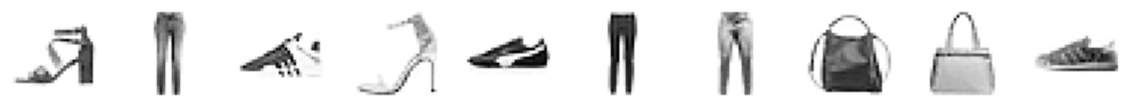

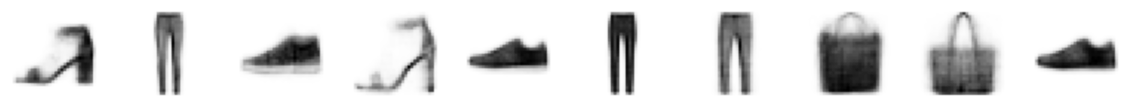

In [56]:
batch_idx = 0
show_images2(x_original_list_normal[batch_idx])
show_images2(x_reconstr_list_normal[batch_idx])

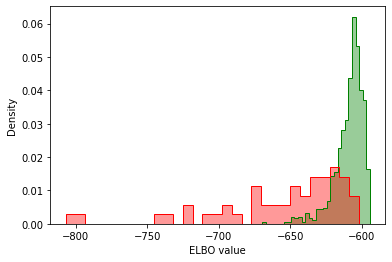

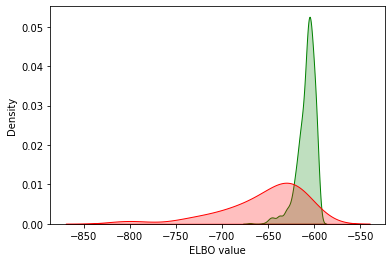

In [57]:
def density_histogram(neg, pos, bins=30, alpha=0.4):
    plt.figure()
    plt.hist(neg, bins=bins, density=True, histtype="bar", color="g", alpha=alpha)
    plt.hist(neg, bins=bins, density=True, histtype="step", color="g", alpha=1)
    plt.hist(pos, bins=bins, density=True, histtype="bar", color="r", alpha=alpha)
    plt.hist(pos, bins=bins, density=True, histtype="step", color="r", alpha=1)
    plt.xlabel("ELBO value")
    plt.ylabel("Density")
    plt.show()


def density_plot(neg, pos):
    plt.figure()
    sns.kdeplot(neg, shade=True, color="g")
    sns.kdeplot(pos, shade=True, color="r")
    plt.xlabel("ELBO value")
    plt.ylabel("Density")

density_histogram(elbos_normal, elbos_anomaly)
density_plot(elbos_normal, elbos_anomaly)

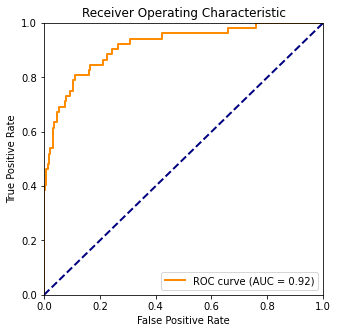

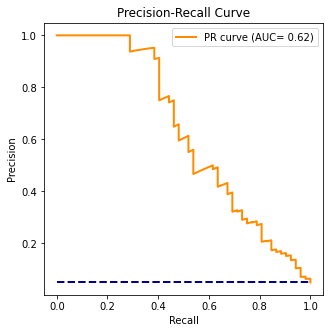

In [58]:
def roc_pr_curves(neg, pos):
    # translate to scores from 0 to 1, where 1 means anomaly (low ELBO) and 0 means normal (high ELBO)
    min_val = min(np.min(neg), np.min(pos))
    max_val = max(np.max(neg), np.max(pos))
    y_true_neg = np.zeros(neg.shape)
    y_true_pos = np.ones(pos.shape)
    y_true = np.concatenate((y_true_neg, y_true_pos))
    y_score = (max_val - np.concatenate((neg, pos))) / (max_val - min_val)

    # get ROC curve values
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=True)
    auroc = auc(fpr, tpr)

    # plot ROC curve
    lw = 2
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # get Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auprc = auc(recall, precision)

    # plot Precision-Recall curve
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.figure(figsize=(5, 5))
    plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label="PR curve (AUC= %0.2f)" % auprc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.show()

roc_pr_curves(elbos_normal, elbos_anomaly)

# visualize the  data distribution in low demension by using the Intermediate results of VAE 


In [59]:
from sklearn.manifold import TSNE

mu_list = torch.Tensor(mu_list)
mu_list = mu_list.detach().cpu().numpy()
#mu_array = np.array(mu_list)

d2_embs = TSNE(n_components=2, perplexity=200, learning_rate="auto", n_iter=10000, random_state=2).fit_transform(mu_list)

/Users/shiyibo/miniforge3/envs/env_cv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import seaborn as sns
import pandas as pd

# fmnist_classes = {0:"Trouser", 1:"Sandal", 2:"Sneaker", 3:"Bag", 4:"Ankle boot", 5:"anomaly"}

def plot_tsne(tsne_embeds, labels):
    #pass
    fig = plt.gcf()
    fig.set_size_inches(13, 13)
    
    rps = [];
    for i in range(len(labels)):
        rps.append(Classes[labels[i]])
    rps = pd.DataFrame(rps)
    rps.rename(columns={0:'type'}, inplace=True)
    
    tsne_embeds = pd.DataFrame(tsne_embeds)
    tsne_embeds.rename(columns={0:'x', 1:'y'}, inplace=True)
    result = pd.concat([tsne_embeds, rps], axis=1)
    #print(result)
    sns.set(style="ticks")
    sns.scatterplot(data = result, x='x', y='y', legend='full', hue='type', palette=sns.color_palette("bright", 5), s=200)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

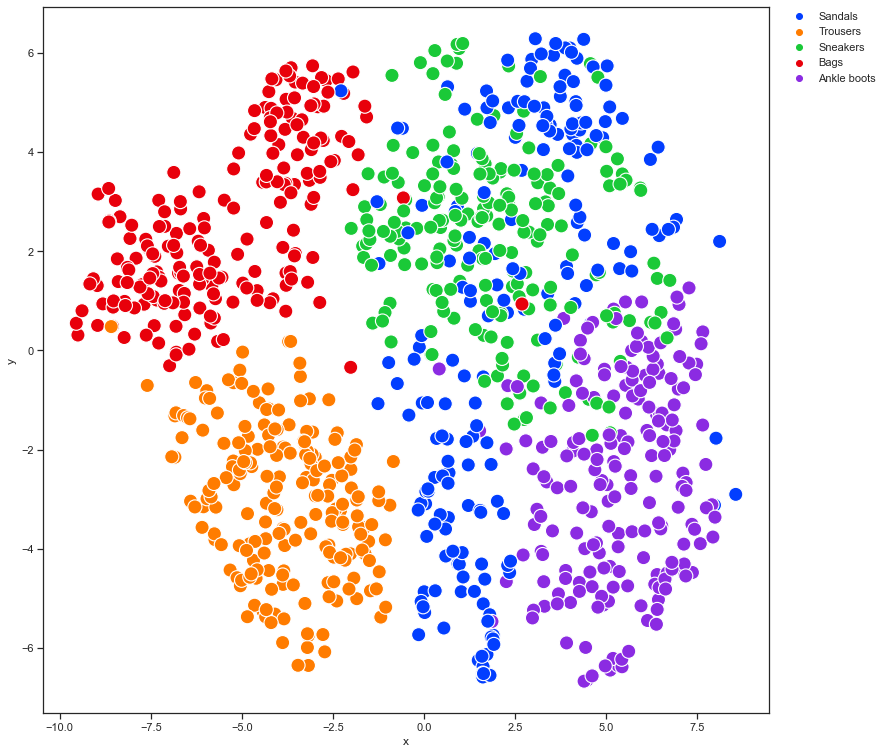

In [61]:
plot_tsne(d2_embs, y_list)